In [51]:
import pandas as pd
import numpy as np
import os, re
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import  LinearSegmentedColormap , ListedColormap

### 합치기

In [52]:
def xyz_to_dict(List:list):
    # 결과를 저장할 딕셔너리 초기화
    result_dict = {'x': [], 'y': [], 'z': []}
    for name in List:
        s = name.split('_')[-1][0]
        result_dict[s].append(name)
    return result_dict
def extract_number(filename):
    numbers = re.findall(r'\d+', filename)
    return [int(num) for num in numbers]

In [53]:
def axis_merge(List: list,Dir: str):
    df_list = [pd.read_csv(os.path.join(Dir,name)) for name in List]
    df = pd.concat(df_list, axis=0)
    df['Time'] = pd.to_datetime(df['Unnamed: 0'])
    df.drop('Unnamed: 0',axis = 1,inplace = True)
    df_sorted = df.sort_values(by='Time')
    return df_sorted
def calculate_time_diff_and_value_counts(df, time_column='Time'):
    # 'Time' 열을 datetime 형식으로 변환
    df[time_column] = pd.to_datetime(df[time_column])

    # 'Time' 열의 차이(diff) 계산
    time_diff = df[time_column].diff()

    # 차이에 대한 값의 빈도수 계산
    value_counts = time_diff.value_counts()

    return value_counts

In [54]:
def same_drop(df:pd.DataFrame):
    df_unique = df.drop_duplicates(subset='Time')
    return df_unique

In [55]:
# 파일 목록을 숫자에 따라 정렬
files = os.listdir('raw_signal')
files.sort(key=extract_number)
dicts = xyz_to_dict(files)

In [56]:
x = axis_merge(dicts['x'],Dir = 'raw_signal')
y = axis_merge(dicts['y'],Dir = 'raw_signal')
z = axis_merge(dicts['z'],Dir ='raw_signal')

In [57]:
x = same_drop(x)
y = same_drop(y)
z = same_drop(z)

In [58]:
x.to_csv('./signal_xyz/x.csv',index=False)
y.to_csv('./signal_xyz/y.csv',index=False)
z.to_csv('./signal_xyz/z.csv',index=False)

### 그러면 x,y,z 불러와서 

In [60]:
import pandas as pd
from scipy.stats import ttest_ind, levene

def perform_t_tests(df1, df2):
    """
    두 데이터프레임의 모든 열에 대해 독립 표본 t-검정을 수행하는 함수입니다.

    Parameters:
    df1 (pandas.DataFrame): 첫 번째 데이터프레임
    df2 (pandas.DataFrame): 두 번째 데이터프레임

    Returns:
    results (pandas.DataFrame): 각 열에 대한 t-검정 결과를 포함하는 데이터프레임
    """
    # 결과를 저장할 빈 리스트를 초기화합니다.
    results = []

    # df1과 df2의 모든 열에 대해 반복합니다.
    for column in df1.columns:
        # 해당 열의 데이터를 추출합니다.
        data1 = df1[column]
        data2 = df2[column]

        # 데이터가 충분한 경우에만 t-검정을 수행
        if len(data1) > 1 and len(data2) > 1:
            # F-테스트를 사용하여 분산 동일
            # 성 검사
            _, p_value_levene = levene(data1, data2)
            equal_var = p_value_levene > 0.05

            # 독립 표본 t-검정 수행
            t_statistic, p_value = ttest_ind(data1, data2, equal_var=equal_var)
            results.append({'Column': column, 'P': round(p_value, 4)})
        else:
            # 데이터가 충분하지 않은 경우 결과 추가
            print(len(data1),len(data2))
            results.append({'Column': column, 'P': np.nan})

    # 결과 리스트를 데이터프레임으로 변환
    results_df = pd.DataFrame(results)
    results_df = results_df.transpose()
    results_df.drop('Column',axis=0, inplace=True)
    results_df = results_df.astype(float)
    return results_df

In [61]:
x = pd.read_csv('./signal_xyz/x.csv')
x['Time'] = pd.to_datetime(x['Time'])
y = pd.read_csv('./signal_xyz/y.csv')
y['Time'] = pd.to_datetime(y['Time'])
z = pd.read_csv('./signal_xyz/z.csv')
z['Time'] = pd.to_datetime(z['Time'])

ch_62, 66으로 split

In [63]:
ch_62 = pd.read_csv('ch_62.csv')
ch_62['start'] = pd.to_datetime(ch_62['start'])
ch_62['end'] = pd.to_datetime(ch_62['end'])
ch_66 = pd.read_csv('ch_66.csv')
ch_66['start'] = pd.to_datetime(ch_66['start'])
ch_66['end'] = pd.to_datetime(ch_66['end'])

In [64]:
def split(df:pd.DataFrame,start:str,end:str):
    return df[(df['Time']>=start) & (df['Time']<=end)]

In [65]:
def selected(List:list,jump = 0, sec = 60):
    front = []
    second =[]
    third = []
    back = []
    back_second = []
    
    for dataframe in List:
        front.append(dataframe.iloc[jump: jump+sec,:])
        second.append(dataframe.iloc[jump+sec: jump+sec*2,:])
        third.append(dataframe.iloc[jump+sec*2: jump+sec*3,:])
        temp = dataframe.iloc[-jump-sec:-jump,:] if jump !=0 else dataframe.iloc[-sec:,:]
        back.append(temp)
        back_second.append(dataframe.iloc[-jump-sec*2:-jump-sec*1,:])
    return front, second,third,back,back_second

In [66]:
def total_split(df:pd.DataFrame,ch:pd.DataFrame):
    pd_split = []
    for i in range(len(ch)-1): #마지막은 drop
        start = ch['start'].iloc[i]
        end = ch['end'].iloc[i]
        pd_split.append(split(df,start,end))
    return selected(pd_split,jump=0,sec = 60)

In [67]:
def sample_mean(List:list):
    result = pd.DataFrame()
    for dataframe in List:
        temp = pd.DataFrame(dataframe.iloc[:,:-1].mean(axis = 0)).transpose()
        result = pd.concat([result,temp],axis=0)
    return result

In [68]:
def t_test_total(df:pd.DataFrame,ch:pd.DataFrame):
    front, second,third, back, back_second = total_split(df,ch) # 데이터 스플릿하기
    front = sample_mean(front)
    second = sample_mean(second)
    third = sample_mean(third)
    back = sample_mean(back)
    back_second = sample_mean(back_second)
    front_last = perform_t_tests(front,back)
    front_second = perform_t_tests(front,second)
    second_third = perform_t_tests(second,third)
    back_two = perform_t_tests(back_second,back)
    List = [front_last,front_second,second_third,back_two]
    result = pd.concat(List,axis=0)
    result.index = ['front-last','front_second','second_third','back_two']
    return result

### 62

In [69]:
t_test_x_62 = t_test_total(x,ch_62)
t_test_x_62

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
front-last,0.6403,0.0489,0.3013,0.2494,0.8532,0.0109,0.0233,0.7960,0.3698,0.6110,0.4647,0.2270,0.8136,0.6022,0.2635,0.0971,0.4046,0.8535,0.4970,0.2595
front_second,0.0663,0.0015,0.0003,0.6049,0.8149,0.0013,0.5377,0.0093,0.2260,0.1277,0.2079,0.3779,0.0079,0.0432,0.1969,0.0427,0.0015,0.6789,0.1416,0.0006
second_third,0.1133,0.5275,0.0861,0.6815,0.6599,0.7991,0.0504,0.0976,0.0050,0.9361,0.0819,0.2290,0.2178,0.1310,0.1486,0.1432,0.3735,0.7808,0.4698,0.7691
back_two,0.4895,0.2430,0.4186,0.8619,0.1033,0.2292,0.1882,0.4295,0.1106,0.1369,0.3125,0.4662,0.4311,0.6752,0.3408,0.0929,0.1454,0.2209,0.9169,0.1861


In [70]:
t_test_y_62 = t_test_total(y,ch_62)
t_test_y_62

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
front-last,0.5565,0.0590,0.3098,0.4887,0.7889,0.0116,0.0527,0.8810,0.5285,0.2784,0.5178,0.0930,0.8054,0.6849,0.2154,0.0622,0.4009,0.5448,0.3337,0.3760
front_second,0.0819,0.0014,0.0010,0.6805,0.9253,0.0011,0.4090,0.0096,0.2580,0.1124,0.1968,0.1877,0.0054,0.0340,0.3018,0.0284,0.0021,0.5993,0.1679,0.0004
second_third,0.1395,0.5886,0.3054,0.7353,0.4172,0.9848,0.2387,0.0959,0.0149,0.7517,0.0635,0.2080,0.2679,0.1844,0.3015,0.2698,0.8451,0.5987,0.6399,0.6710
back_two,0.5025,0.1447,0.4308,0.7262,0.2224,0.3012,0.1196,0.3645,0.1994,0.1219,0.1138,0.4364,0.4845,0.3736,0.3443,0.1050,0.2268,0.2784,0.8151,0.1789


In [71]:
t_test_z_62 = t_test_total(z,ch_62)
t_test_z_62

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
front-last,0.4783,0.9761,0.1486,0.0470,0.6145,0.9499,0.0454,0.4857,0.2111,0.1657,0.2948,0.7747,0.1369,0.4419,0.6642,0.0117,0.3265,0.3773,0.2039,0.2368
front_second,0.0318,0.0037,0.4792,0.2376,0.0092,0.0003,0.5278,0.0009,0.9597,0.1703,0.2699,0.0021,0.5819,0.0109,0.0360,0.0253,0.9246,0.7294,0.5846,0.3181
second_third,0.0007,0.0001,0.4047,0.0088,0.0001,0.0039,0.7337,0.0001,0.2003,0.1319,0.2196,0.0276,0.2518,0.0007,0.0823,0.0565,0.0116,0.6476,0.0931,0.0002
back_two,0.0784,0.1667,0.6817,0.0236,0.0167,0.5790,0.1185,0.0957,0.1179,0.5197,0.0668,0.2821,0.2448,0.1707,0.1815,0.0418,0.0640,0.1503,0.8323,0.0011


### 66

In [72]:
t_test_x_66 = t_test_total(x,ch_66)
t_test_x_66 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
front-last,0.1283,0.4734,0.0307,0.0133,0.6173,0.2575,0.1452,0.0483,0.0178,0.7765,0.0754,0.8944,0.1362,0.0838,0.0067,0.2927,0.1811,0.5636,0.9146,0.1277
front_second,0.8948,0.5104,0.7413,0.7264,0.4383,0.7509,0.3577,0.5912,0.2492,0.4301,0.6392,0.4879,0.6178,0.5070,0.6691,0.7376,0.4319,0.3126,0.6235,0.7429
second_third,0.2043,0.4102,0.8032,0.8078,0.9316,0.1586,0.1080,0.8435,0.2416,0.4576,0.1375,0.6536,0.9104,0.3730,0.1538,0.0725,0.5854,0.8408,0.8948,0.2203
back_two,0.9649,0.2511,0.0694,0.1572,0.2126,0.0260,0.1269,0.1332,0.6403,0.1693,0.4831,0.3102,0.2097,0.3746,0.8092,0.2427,0.0254,0.0805,0.8449,0.0367


In [73]:
t_test_y_66 =t_test_total(y,ch_66)
t_test_y_66 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
front-last,0.1567,0.4486,0.0467,0.0101,0.8197,0.3583,0.1063,0.0588,0.0771,0.8808,0.0690,0.8604,0.2360,0.1014,0.0073,0.2421,0.1548,0.5495,0.9280,0.1352
front_second,0.8664,0.3879,0.7147,0.3929,0.3124,0.5288,0.1790,0.6983,0.3331,0.2107,0.4876,0.5216,0.8291,0.5765,0.3536,0.7387,0.4006,0.2588,0.3592,0.6821
second_third,0.2062,0.3443,0.7955,0.7151,0.9788,0.3285,0.2436,0.9607,0.3375,0.3155,0.2834,0.3804,0.5009,0.6599,0.1612,0.1440,0.7293,0.9274,0.5279,0.4575
back_two,0.8874,0.1071,0.0993,0.2660,0.1892,0.0326,0.1843,0.1633,0.5890,0.0788,0.6462,0.2565,0.2870,0.3543,0.7290,0.2437,0.0833,0.1889,0.6588,0.0693


In [74]:
t_test_z_66=t_test_total(z,ch_66)
t_test_z_66

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
front-last,0.0345,0.1974,0.5333,0.9600,0.2508,0.7483,0.1501,0.5264,0.6763,0.0778,0.0875,0.6704,0.5524,0.6097,0.4343,0.5118,0.2146,0.0352,0.3813,0.0791
front_second,0.3520,0.4164,0.1111,0.6250,0.3513,0.0338,0.9102,0.4293,0.1977,0.9677,0.4793,0.1363,0.5790,0.3141,0.2262,0.0421,0.9998,0.3739,0.0966,0.6134
second_third,0.2678,0.2394,0.0980,0.9227,0.3061,0.4545,0.0632,0.2029,0.7452,0.0683,0.3921,0.3724,0.0216,0.3670,0.1799,0.8142,0.8332,0.7629,0.6655,0.0985
back_two,0.4281,0.9978,0.8607,0.1850,0.4508,0.5412,0.3876,0.6087,0.1750,0.4743,0.8565,0.6783,0.7840,0.7637,0.7127,0.4582,0.1364,0.3608,0.4595,0.1395


### theshold 적용

In [75]:
# 임계값을 적용하는 함수
def apply_threshold(df, threshold):
    df = df.astype(float)
    return df.applymap(lambda x: 'ok' if float(x) <= threshold else 'no')
threshold = 0.1

62

In [76]:
apply_threshold(t_test_x_62,threshold)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
front-last,no,ok,no,no,no,ok,ok,no,no,no,no,no,no,no,no,ok,no,no,no,no
front_second,ok,ok,ok,no,no,ok,no,ok,no,no,no,no,ok,ok,no,ok,ok,no,no,ok
second_third,no,no,ok,no,no,no,ok,ok,ok,no,ok,no,no,no,no,no,no,no,no,no
back_two,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,ok,no,no,no,no


In [77]:
apply_threshold(t_test_y_62,threshold)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
front-last,no,ok,no,no,no,ok,ok,no,no,no,no,ok,no,no,no,ok,no,no,no,no
front_second,ok,ok,ok,no,no,ok,no,ok,no,no,no,no,ok,ok,no,ok,ok,no,no,ok
second_third,no,no,no,no,no,no,no,ok,ok,no,ok,no,no,no,no,no,no,no,no,no
back_two,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no


In [78]:
apply_threshold(t_test_z_62,threshold)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
front-last,no,no,no,ok,no,no,ok,no,no,no,no,no,no,no,no,ok,no,no,no,no
front_second,ok,ok,no,no,ok,ok,no,ok,no,no,no,ok,no,ok,ok,ok,no,no,no,no
second_third,ok,ok,no,ok,ok,ok,no,ok,no,no,no,ok,no,ok,ok,ok,ok,no,ok,ok
back_two,ok,no,no,ok,ok,no,no,ok,no,no,ok,no,no,no,no,ok,ok,no,no,ok


66

In [79]:
apply_threshold(t_test_x_66,threshold)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
front-last,no,no,ok,ok,no,no,no,ok,ok,no,ok,no,no,ok,ok,no,no,no,no,no
front_second,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no
second_third,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,ok,no,no,no,no
back_two,no,no,ok,no,no,ok,no,no,no,no,no,no,no,no,no,no,ok,ok,no,ok


In [80]:
apply_threshold(t_test_y_66,threshold)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
front-last,no,no,ok,ok,no,no,no,ok,ok,no,ok,no,no,no,ok,no,no,no,no,no
front_second,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no
second_third,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no
back_two,no,no,ok,no,no,ok,no,no,no,ok,no,no,no,no,no,no,ok,no,no,ok


In [81]:
apply_threshold(t_test_z_66,threshold)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
front-last,ok,no,no,no,no,no,no,no,no,ok,ok,no,no,no,no,no,no,ok,no,ok
front_second,no,no,no,no,no,ok,no,no,no,no,no,no,no,no,no,ok,no,no,ok,no
second_third,no,no,ok,no,no,no,ok,no,no,ok,no,no,ok,no,no,no,no,no,no,ok
back_two,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no


### 시각화

In [82]:
def color_mapping(val):
    if val == 'No':
        return 'red'
    elif val == 'OK':
        return 'blue'
    else:
        return 'white'

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

def plot_heatmaps(df1, df2, df3, threshold,Type):
    """
    세 개의 p-value 데이터프레임에 대해, 임계값보다 작으면 파란색, 크거나 같으면 빨간색으로 배경색을 지정하는 히트맵을 3행 1열 구조로 그리는 함수
    """
    df1 = df1.fillna(0).astype(float)
    df2 = df2.fillna(0).astype(float)
    df3 = df3.fillna(0).astype(float)

    fig, axs = plt.subplots(3, 1, figsize=(20, 8))

    # 사용자 정의 컬러맵 생성 (파란색과 빨간색만 포함)
    cmap1 = ListedColormap(['blue'])
    cmap2 = ListedColormap(['red'])


    # 세 개의 데이터프레임 각각에 대해 히트맵 생성
    dataframes = [df1, df2, df3]
    names = [f'{Type}_X', f'{Type}_Y', f'{Type}_Z']
    for idx, (df, name) in enumerate(zip(dataframes, names)):
        ax = axs[idx]

        # 임계값보다 작은 값에 대한 마스크 생성
        mask_lower = df < threshold
        # 임계값보다 크거나 같은 값에 대한 마스크 생성
        mask_higher = df >= threshold

        # 마스크에 따라 서로 다른 컬러맵 적용
        sns.heatmap(df, cmap=cmap1, annot=True, cbar=False, linewidths=.5, ax=ax, 
                    mask=mask_higher, annot_kws={"size": 8}, fmt=".3f")
        sns.heatmap(df, cmap=cmap2, annot=True, cbar=False, linewidths=.5, ax=ax, 
                    mask=mask_lower, annot_kws={"size": 8}, fmt=".3f")

        ax.set_title(name)

    plt.tight_layout()
    plt.show()

    

62

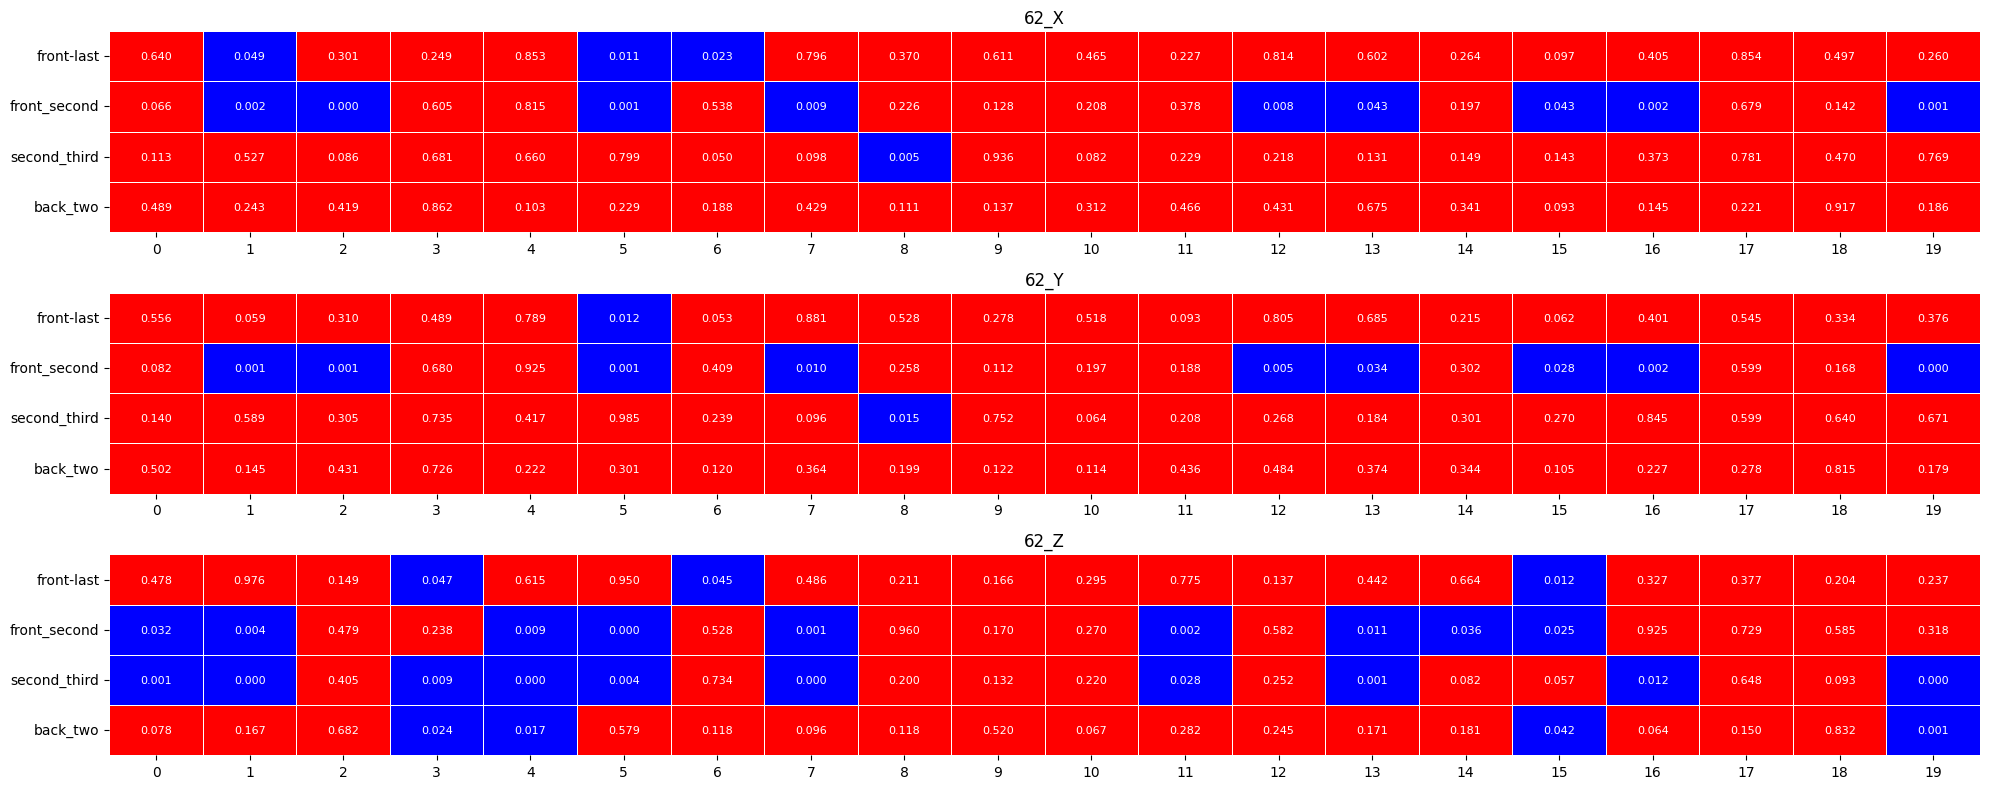

In [86]:
plot_heatmaps(t_test_x_62,t_test_y_62,t_test_z_62,0.05,'62')

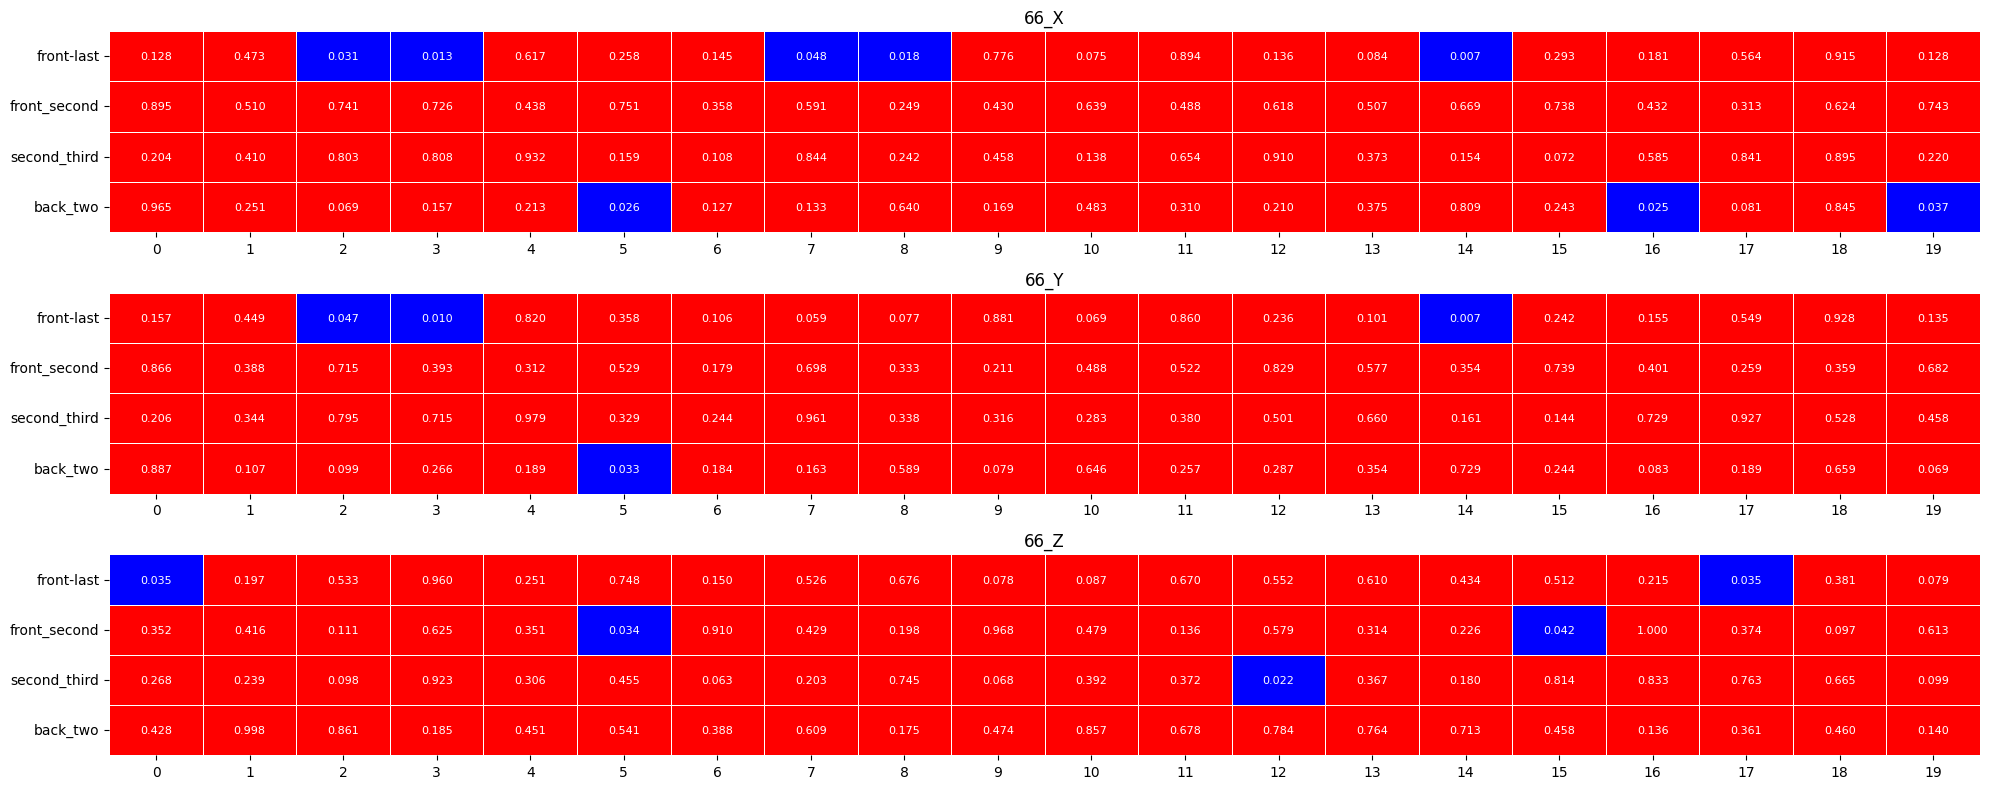

In [87]:
plot_heatmaps(t_test_x_66,t_test_y_66,t_test_z_66,0.05,'66')